<a href="https://colab.research.google.com/github/taji99/python_basic/blob/master/200726_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みの実装
im2colを使って畳み込みを実装します。

## ●im2colの実装
im2colにより、フィルタの形状に合わせて画像を行列に変換します。  
この行列に変換された画像と、同じく行列に変換されたフィルタの行列積により、畳み込みを行うことができます。  
以下は、チャンネル数が1、バッチサイズが1、パディングなしでストライドが1の場合のシンプルなim2colのコードです。

In [1]:
import numpy as np

def im2col(img, flt_h, flt_w):  # 入力画像、フィルタの高さ、幅
   
    img_h, img_w = img.shape  # 入力画像の高さ、幅
    out_h = img_h - flt_h + 1  # 出力画像の高さ（パディング無し、ストライド1）
    out_w = img_w - flt_w + 1  # 出力画像の幅（パディング無し、ストライド1）

    cols = np.zeros((flt_h*flt_w, out_h*out_w)) # 生成される行列のサイズ

    for h in range(out_h):
        h_lim = h + flt_h  # h:フィルタがかかる領域の上端、h_lim:フィルタがかかる領域の下端
        for w in range(out_w):
            w_lim = w + flt_w  # w:フィルタがかかる領域の左端、w_lim:フィルタがかかる領域の右端
            cols[:, h*out_w+w] = img[h:h_lim, w:w_lim].reshape(-1)

    return cols

im2colを使って、画像を行列に変換します。

In [2]:
img = np.array([[1, 2, 3, 4],  # 入力画像
                [5, 6, 7, 8],
                [9, 10,11,12],
                [13,14,15,16]])

cols = im2col(img, 2, 2)  # 入力画像と、フィルタの高さ、幅を渡す
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


なお、実際には、様々なバッチサイズ、チャンネル数、パディング幅、ストライドに対応し、forによる繰り返しを最小化した以下ようなim2colのコードが使用されます。  

In [4]:
def im2col(images, flt_h, flt_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    out_h = (img_h - flt_h + 2*pad) // stride + 1  # 出力画像の高さ
    out_w = (img_w - flt_w + 2*pad) // stride + 1  # 出力画像の幅
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

In [5]:
img = np.array([[[[1, 2, 3, 4],  # 入力画像
                  [5, 6, 7, 8],
                  [9, 10,11,12],
                  [13,14,15,16]]]])

cols = im2col(img, 2, 2, 1, 0)  # 入力画像、フィルタの高さ、幅、ストライド、パディング幅
print(cols)

[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


## ●畳み込みの実装
im2colを使って、畳み込みを実装します。  
今回は、scikit-learnから手書き文字の画像を読み込み、畳み込みを行います。

(1797, 64)


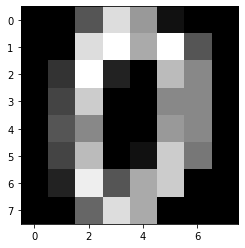

In [6]:
import matplotlib.pyplot as plt 
from sklearn import datasets

digits = datasets.load_digits()
print(digits.data.shape)

image = digits.data[0].reshape(8, 8)
plt.imshow(image, cmap="gray")
plt.show() 

以下の、シンプルなim2colの関数を使います。

In [7]:
def im2col(img, flt_h, flt_w, out_h, out_w):  # 入力画像、フィルタの高さ、幅、出力画像の高さ、幅

    cols = np.zeros((flt_h*flt_w, out_h*out_w)) # 生成される行列のサイズ

    for h in range(out_h):
        h_lim = h + flt_h  # h:フィルタがかかる領域の上端、h_lim:フィルタがかかる領域の下端
        for w in range(out_w):
            w_lim = w + flt_w  # w:フィルタがかかる領域の左端、w_lim:フィルタがかかる領域の右端
            cols[:, h*out_w+w] = img[h:h_lim, w:w_lim].reshape(-1)

    return cols

im2colで画像を行列に変換し、フィルタとの行列積により畳み込みを行います。

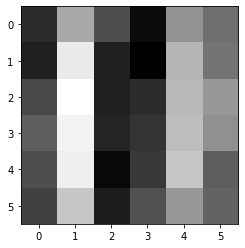

In [8]:
flt = np.array([[-1, 1, -1,],  # 縦の線を強調するフィルタ
                [-1, 1, -1,],
                [-1, 1, -1,]])
flt_h, flt_w = flt.shape
flt = flt.reshape(-1)  # 行数が1の行列

img_h, img_w = image.shape  # 入力画像の高さ、幅
out_h = img_h - flt_h + 1  # 出力画像の高さ（パディング無し、ストライド1）
out_w = img_w - flt_w + 1  # 出力画像の幅（パディング無し、ストライド1）

cols = im2col(image, flt_h, flt_w, out_h, out_w)

image_out = np.dot(flt, cols)  # 畳み込み
image_out = image_out.reshape(out_h, out_w)
plt.imshow(image_out, cmap="gray")
plt.show() 

フィルタにより、縦の線が強調されました。  
また、画像サイズが小さくなっていることも確認できます。  
畳み込み層においては、このような畳み込みにより画像の特徴の抽出が行われます。  